# Working with streaming data: Using the Twitter API to capture tweets
If you've done any data science or data analysis work, you've probably read in a csv file or connected to a database and queried rows. A typical data analysis workflow involves retrieving stored data, loading it into an analysis tool, and then exploring it. This works well when you're dealing with historical data such as analyzing what products a customer at your online store is most likely to purchase, or whether people's diets changed in response to advertising. But what if you want to predict stock prices in real-time? Or figure out what people are watching on television right now?

As more data is generated, it's becoming increasingly important to be able to work with real-time data. Real-time, or streaming, data is generated continuously, and in the case of the stock market, there can be millions of rows generated every hour. Due to size and time constraints, there often isn't a neat dataset that you can analyze — you'll need to either store the data to analyze later, or analyze it in real time, as you get it.

Being able to work with streaming data is a critical skill for any aspiring data scientist. In this post, we'll talk about strategies for working with streaming data, and walk through an example where we stream and store data from Twitter.

[source](https://www.dataquest.io/blog/streaming-data-python/)

# Twitter

For those of you unfamiliar with Twitter, it's a social network where people post short, 140-character, status messages called tweets. Because tweets are sent out continuously, Twitter is a great way to figure out how people feel about current events. In this post, we'll create a tool that enables us to find out how people feel about Donald Trump and Hillary Clinton, both of whom are US Presidential candidates. To do this, we'll need to:

* Stream tweets from the Twitter API.
* Filter out the tweets that aren't relevant.
* Process the tweets to figure out what emotions they express about each candidate.
* Store the tweets for additional analysis.

We'll build up the code as we go through the post, but you can look here if you want to see the finished version.

## Event-driven programming
As we mentioned earlier, in a typical data analysis workflow, you'll:

1. Open a csv file.
2. Iterate over the rows.
3. Discover insights and create visualizations.

This flow might involve a script like this:

17.656666666666666


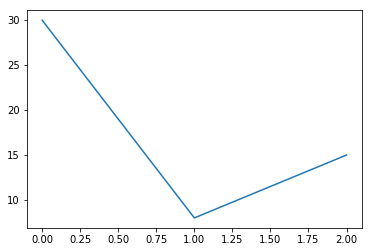

In [2]:
%matplotlib inline
import pandas

data = pandas.read_csv("products_sold.csv")

# Print out the mean selling price.
print(data["price"].mean())

# Plot out the sale prices.
data["price"].plot()

In the above example, the Python interpreter starts at the first line in our program, then proceeds through it until it's finished. This is called procedural programming, because the program is executing in a fixed order, like a procedure.

We could modify the program above to work with a set of tweets that we've downloaded beforehand:

In [3]:
def get_sentiment(text):
    return "positive"

In [4]:
import pandas

tweets = pandas.read_csv("tweets.csv")

# Get the emotion (sentiment) in each tweet.
# This is an example function that we'll assume is defined further up.
sentiment = tweets["text"].apply(get_sentiment)

# Plot out the sentiment in each tweet.
# sentiment.plot()

print(sentiment)

0    positive
1    positive
Name: text, dtype: object


Although working with a csv file of tweets is straightforward, it's unclear how we'd modify this program to work with a streaming tweets. With streaming tweets, we wouldn't have a nice csv file — we'd have to retrieve the tweets in real-time. To work with streaming tweets, we need to:

* Open a persistent connection to the Twitter API.
* Process each tweet that we receive.
* Store the processed tweets.

In order to accomplish this, we'll need to use a programming paradigm called event-driven programming. In event-driven programming, the program executes actions based on external inputs. A good example is a web browser. A web browser might consist of a few functions:

In [5]:
def go_to_site(url):
    # Given a url, visit the site.
    # ...
    pass

def go_back():
    # Go back to the last site.
    # ...
    pass
    
def go_forward():
    # Go forward to the next site (if applicable)
    # ...
    pass
    
def reload():
    # Reload the current page.
    # ...
    pass

When the web browser loads, it doesn't do anything, and instead waits for the user to take an action. The user typing a URL into the URL bar and hitting enter will trigger the function **go_to_site**, which will render the content of that URL.

In a web browser, a function could be called once, many times, or not at all. It all depends on what the user does. The program isn't following a procedure, and is instead waiting for external actions. Each action can be called an event, which is what makes this style of programming event-driven. Functions can be tied to events (in this case button presses by the user). Each function that is tied to an event is called a callback function for that event. For example, entering a URL in the browser bar is tied to the **go_to_site** _callback function_, which then visits the site. Clicking the back button is tied to the **go_back** _callback function_, which visits the previous site.

![Web Page](https://www.dataquest.io/blog/content/images/chrome_screen.png)
_A screenshot of the Chrome browser — you can see the buttons that are tied to each callback function._

In the web browser example, we're relying on the user to generate events, but we can also rely on other programs to generate events. Let's say that we have a program that streams tweets, and then calls our program to process them. We'd only need a few functions in our program:

In [6]:
def filter_tweet(tweet):
    # Remove any tweets that don't match our criteria.
    if not tweet_matches_criteria(tweet):
        return
    # Process the remaining tweets.
    process_tweet(tweet)

def process_tweet(tweet):
    # Annotate the tweet dictionary with any other information we need.
    tweet["sentiment"] = get_sentiment(tweet)
    # Store the tweet.
    store_tweet(tweet)
    
def store_tweet(tweet):
    # Saves a tweet for later processing.
    # ...
    pass

We setup a separate program to get tweets in real-time — let's called this the **streamer**. We register **filter_tweet** as a callback with **streamer**, so **filter_tweet** will be called every time a new tweet is received. We're able to decide if we want to process the tweet or not, then call **process_tweet** and **store_tweet** to handle the tweet.

## The Twitter Streaming API
In order to make it easy to work with real-time tweets, Twitter provides the Twitter Streaming API. There are quite a few rules about how to stream tweets from Twitter, but the main ones are:

* Create a persistent connection to the Twitter API, and read each connection incrementally.
* Process tweets quickly, and don't let your program get backed up.
* Handle errors and other issues properly.

There are a variety of clients for the Twitter Streaming API across all major programming languages. For Python, there are quite a few, which you can find [here](https://dev.twitter.com/resources/twitter-libraries). The most popular is [tweepy](https://github.com/tweepy/tweepy), which allows you to connect to the streaming API and handle errors properly.

Although tweepy handles most of the logistics of dealing with the stream for us, we'll walk through what's happening behind the scenes.

### Opening a connection
The first step is to open a connection to the Twitter Streaming API. This involves opening a persistent HTTP connection. Tweepy does this with the following code segment, which you can find [here](https://github.com/tweepy/tweepy/blob/master/tweepy/streaming.py#L241):

```python
resp = self.session.request('POST',
                            url,
                            data=self.body,
                            timeout=self.timeout,
                            stream=True,
                            auth=auth,
                            verify=self.verify)
```

The above code segment makes a request using the python requests library, and passed the stream=True keyword argument to keep the connection open forever. Whenever a new tweet is created on Twitter, it will send the tweet to our program over the connection.

You may notice the url parameter above. We can gather all the tweets generated on Twitter by hitting the firehose.json API endpoint. Gathering all tweets at once would overwhelm our computer, though, since it's hundreds of thousands of tweets a minute. This access is also restricted, and not everyone can access the firehose data. We'll instead have to access the filter.json API endpoint. This API endpoint takes in a list of strings, then searches for those strings in tweets. Instead of all tweets, you get a filtered subset, which makes them much easier for your local machine to work with.

You may also notice the auth keyword argument above. The Twitter Streaming API requires authentication. You'll need to create a developer account, then pass your credentials into tweepy so it can pass them to Twitter. We'll walk through how to do this in a later section.

### Listening for tweets
Once we open a connection, we'll need to listen for tweets coming over the connection. Twitter sends data in plain text over the connection, like this:

```bash
HTTP/1.1 200 OK
Content-Type: application/json
Transfer-Encoding: chunked

1953
{"retweet_count":0,"text":"Man I like me some @twitterapi","entities":{"urls":[],"hashtags":[],"user_mentions":[{"indices":[19,30],"name":"Twitter API","id":6253282,"screen_name":"twitterapi","id_str":"6253282"}]},"retweeted":false,"in_reply_to_status_id_str":null,"place":null,"in_reply_to_user_id_str":null,"coordinates":null,"source":"web","in_reply_to_screen_name":null,"in_reply_to_user_id":null,"in_reply_to_status_id":null,"favorited":false,"contributors":null,"geo":null,"truncated":false,"created_at":"Wed Feb 29 19:42:02 +0000 2012","user":{"is_translator":false,"follow_request_sent":null,"statuses_count":142,"profile_background_color":"C0DEED","default_profile":false,"lang":"en","notifications":null,"profile_background_tile":true,"location":"","profile_sidebar_fill_color":"ffffff","followers_count":8,"profile_image_url":"http:\/\/a1.twimg.com\/profile_images\/1540298033\/phatkicks_normal.jpg","contributors_enabled":false,"profile_background_image_url_https":"https:\/\/si0.twimg.com\/profile_background_images\/365782739\/doof.jpg","description":"I am just a testing account, following me probably won't gain you very much","following":null,"profile_sidebar_border_color":"C0DEED","profile_image_url_https":"https:\/\/si0.twimg.com\/profile_images\/1540298033\/phatkicks_normal.jpg","default_profile_image":false,"show_all_inline_media":false,"verified":false,"profile_use_background_image":true,"favourites_count":1,"friends_count":5,"profile_text_color":"333333","protected":false,"profile_background_image_url":"http:\/\/a3.twimg.com\/profile_background_images\/365782739\/doof.jpg","time_zone":"Pacific Time (US & Canada)","created_at":"Fri Sep 09 16:13:20 +0000 2011","name":"fakekurrik","geo_enabled":true,"profile_link_color":"0084B4","url":"http:\/\/blog.roomanna.com","id":370773112,"id_str":"370773112","listed_count":0,"utc_offset":-28800,"screen_name":"fakekurrik"},"id":174942523154894848,"id_str":"174942523154894848"}
```

The first few lines are HTTP connection headers, which we can ignore, as these are only used when establishing the connection. Once we establish the connection, we'll get back a series of numbers and JSON encoded tweets. The numbers indicate that tweet data is being sent over the connection, and tell the program how many bytes to read from the connection to get the tweet data. In this case, 1953 is the number of bytes to read off of the stream until the end of the tweet. Reading the next 1953 bytes will get us the data for the tweet.

As you can see, the data contains not just the text of the tweet, but information on who sent it, how many followers they have, and other metadata. This data is in JSON format, and can be read in and processed using the Python json library. As more tweets are sent to us from the Twitter API, they'll follow a similar format, of the length in bytes on one line, and the data for the tweet on the next length. All the tweets will be sent through the same persistent connection.

### Calling the callback
Once tweepy decodes the tweet data, it passes the data to a preregistered callback function. You can see the code for it here, and we'll copy a portion below:

```python
def _data(self, data):
    if self.listener.on_data(data) is False:
        self.running = False
```

**self.listener** is actually an instance of a user-defined class which has a method called **on_data**. **on_data** processes the tweet, then returns **True** or **False**. If **on_data** returns **True**, it processed the tweet okay, and everything is fine. If **on_data** returns **False**, the connection will be shut down.

We'll place our custom code to process the tweet in the **listener**, and then return the appropriate status (**True** or **False**).

### Rate limiting and other concerns
The Twitter Streaming API has [rate limits](https://dev.twitter.com/streaming/overview/connecting), and prohibits too many connection attempts happening too quickly. It also prevents too many connections being made to it using the same authorization keys. Thankfully, tweepy takes care of these details for us, and we can focus on our program.

The main thing that we have to be aware of is the queue of tweets that we're processing. If we take too long to process tweets, they will start to get queued, and Twitter may disconnect us. This means that processing each tweet needs to be extremely fast.

## Setting up Tweepy
Now that we understand how streaming tweets from Twitter works, we can go ahead and setup tweepy to start streaming data. The first thing we'll need to do is visit the [Twitter Developer Center](https://dev.twitter.com/) and create a developer account. This account will enable us to create credentials that let us authenticate with the Twitter Streaming API.

After creating the account, we can go to the [Application Console](https://apps.twitter.com/) and create a new Twitter application. This will let us get credentials specific to the application, which will let us connect to the API.

![Twitter](https://www.dataquest.io/blog/content/images/twitter_make_app.png)
_Fill out all the values to make a Twitter application._

As you can see in the screenshot above, you'll want to leave the "Callback URL" field blank. In the "Website" field fill in a website if you have one, otherwise you can enter a placeholder value like <https://www.site.com>.

Once you create your application, you can click on the "Keys and Access Tokens" tab to get your credentials. You'll need to get the following from under "Application Settings":

* **Consumer Key (API Key)** — we'll refer to this as **TWITTER_APP_KEY**.
* **Consumer Secret (API Secret)** — we'll refer to this as **TWITTER_APP_SECRET**.

You'll also need to do the following in the section under "Your Access Token":

* Click "Create my access token":
* Get the value called Access Token — we'll refer to this as TWITTER_KEY.
* Get the value called Access Token Secret — we'll refer to this as TWITTER_SECRET.



We can setup tweepy to authenticate with Twitter with the following code:

```python
auth = tweepy.OAuthHandler(TWITTER_APP_KEY, TWITTER_APP_SECRET)
auth.set_access_token(TWITTER_KEY, TWITTER_SECRET)
```

Then, we can create an API object to pull data from Twitter — we'll pass in the authentication:

```python
api= tweepy.API(auth)
```

## Setting up a listener
As we noted above, opening a Twitter stream using tweepy requires a user-defined **listener** class. We'll need to subclass the **StreamListener** class, and implement some custom logic. The **StreamListener** class has a method called **on_data**. This method will automatically figure out what kind of data Twitter sent, and call an appropriate method to deal with the specific data type. It's possible to deal with events like users sending direct messages, tweets being deleted, and more. For now, we only care about when users post tweets. Thus, we'll need to override the on_status method:

```python
class StreamListener(tweepy.StreamListener):

    def on_status(self, status):
        print(status.text)
```

The above code will create a listener that prints the text of any tweet that comes from the Twitter API.

We'll also need to override the on_error method of StreamListener so that we can handle errors coming from the Twitter API properly. The Twitter API will send a 420 status code if we're being rate limited. If this happens, we'll want to disconnect. If it's any other error, we'll keep going:

```python
class StreamListener(tweepy.StreamListener):

    def on_status(self, status):
        print(status.text)
        
    def on_error(self, status_code):
        if status_code == 420:
            return False
```

## Starting the listener
Once we setup the listener, we're ready to wire everything up, and stream tweets that mention **Donald Trump** or **Hillary Clinton**.

In the below code segment, we'll:

* Create an instance of our StreamListener class.
* Create an instance of the tweepy Stream class, which will stream the tweets.
    * We pass in our authentication credentials (api.auth) so that Twitter allows us to connect.
    * We pass in our stream_listener so that our callback functions are called.
* Start streaming tweets by calling the filter method. This will start streaming tweets from the filter.json API endpoint, and passing them to our listener callback.
    * We pass in a list of terms to filter on, as the API requires.
    
```python
stream_listener = StreamListener()
stream = tweepy.Stream(auth=api.auth, listener=stream_listener)
stream.filter(track=["trump", "clinton", "hillary clinton", "donald trump"])
```

Once we set this up, we have a simple Twitter streamer! It won't do much (just print out the text of all tweets mentioning Hillary Clinton or Donald Trump), but we've accomplished a lot with very little code.

## Filtering events

We want to look at how people feel about each presidential candidate. This means that we want to ignore retweets. Retweets show up in the stream of data from the Twitter API, but the same text can show up hundreds or thousands of times. This will skew our results, as one person's tweet will effectively count thousands of times in our analysis. The tweet that is passed into the on_status method is an instance of the Status class. This class has properties describing the tweet, including the property retweeted_status, which tells us whether or not the tweet is a retweet. We can filter out retweets by checking for the retweeted_status property. In the below code, we:

* Modify the on_status function to filter out retweets.
    * If the retweeted_status property exists, then don't process the tweet.
    * Print all tweets that aren't retweets.
    
```python
def on_status(self, status):
    if status.retweeted_status:
        return
    print(status.text)
```

So far, we've used the text property and the retweeted_status property of the tweet. You can find a full list of available properties here. The values come from the Twitter API, and tweepy then sets them as properties of an instance of the Status class. We could perform additional filtering by using fields such as:

* **retweet_count** — the number of times a tweet has been retweeted.
* **withheld_in_countries** — the tweet has been withheld in certain countries.
* **favorite_count** — the number of times the tweet has been favorited by other users.

For example, the below code will filter out any tweets with less than **10** favorites:

```python
def on_status(self, status):
    if status.favorite_count is None or status.favorite_count < 10:
        return
    print(status.text)
```

## Extracting information

Because we have to process tweets quickly, we don't want to do anything too intensive before we save them. We'll mainly want to extract and store the properties we want. Because we're interested in analyzing the emotions of people who support **Hillary Clinton** or **Donald Trump**, there are a few fields that will be interesting to us:

* The user's description (**status.user.description**). This is the description the user who created the tweet wrote in their biography.
* The user's location (**status.user.location**). This is the location the user who created the tweet wrote in their biography.
* The screen name of the user (**status.user.screen_name**).
* When the user's account was created (**status.user.created_at**).
* How many followers the user has (**status.user.followers_count**).
* The background color the user has chosen for their profile (**status.user.profile_background_color**).
* The text of the tweet (**status.text**).
* The unique id that Twitter assigned to the tweet (**status.id_str**).
* When the tweet was sent (**status.created_at**).
* How many times the tweet has been retweeted (**status.retweet_count**).
* The tweet's coordinates (**status.coordinates**). The geographic coordinates from where the tweet was sent.

These properties will enable us to analyze interesting things like whether users with more followers support Trump or Clinton.

We can extract this information in the on_status method:

```python
description = status.user.description
loc = status.user.location
text = status.text
coords = status.coordinates
name = status.user.screen_name
user_created = status.user.created_at
followers = status.user.followers_count
id_str = status.id_str
created = status.created_at
retweets = status.retweet_count
bg_color = status.user.profile_background_color
```

## Processing the tweets
Because we're interested in the emotion of people who support both presidential candidates, we'll want to analyze the text of each tweet to figure out the sentiments it expresses. This will tell us if people usually tweet positive things about Hillary Clinton, for example. We can use a method called sentiment analysis to tag each tweet with a sentiment score, from -1 to 1. A -1 means that the tweet is very negative a 0 is neutral, and a 1 means that the tweet is very positive. Sentiment analysis tools typically generate this score by seeing if words known to indicate negative and positive sentiment occur in a string. For example, if the word hate occurs in a string, it is more likely to be negative. Because sentiment analysis is essentially string matching, it is extremely quick to work, which is important for us, since the longer we take to process, the more likely that we'll fall behind on processing tweets and be disconnected.

In order to perform sentiment analysis, we can use a library called TextBlob, which allows us to do sentiment analysis in Python, among other natural language processing tasks.

The below code will:

* Initialize the TextBlob class on the text of the tweet.
* Get the sentiment score from the class.

```python
blob = TextBlob(text)
sent = blob.sentiment
```

Once we have the sent object, we'll need to extract polarity and subjectivity from it. polarity is the negativity or positivity of the tweet, on a -1 to 1 scale. subjectivity is how objective or subjective the tweet is. 0 means that the tweet is very objective, and 1 means that it is very subjective. In order to do this, we just need to access properties:

```python
polarity = sent.polarity
subjectivity = sent.subjectivity
```

## Storing the tweets
Once we have all the data we want on each tweet, we're ready to store it for later processing. It's possible to store our data in a csv file, but a csv file makes it hard to query the data. If we want to read from a csv file, we either have to load the whole thing, or go through a convoluted process to query and only load the pieces we want.

A good place to store our data is in a database. Because they are commonly used and easy to query, we'll use a relational database. SQLite is the simplest to use major relational database, as it doesn't require any processes to be running, and everything is stored in a single file.

In order to access the database, we'll use the dataset package, which makes it extremely simple to access a database and store data. Instead of creating a database and tables, we simply store data, and the dataset package will take care of automatically creating the database and all the tables we need.

We have to first connect to our database using a connection string:

```python
import dataset
db = dataset.connect("sqlite:///tweets.db")
```

When using SQLite, if the database file (in this case, tweets.db) doesn't exist, it will be automatically created in the current folder.

Then we have to dump our coordinates json dictionary to a string, so we can store it:

```python
if coords is not None:
    coords = json.dumps(coords)
```

Finally, we can add code in the on_status method to write a tweet to the database:

```python
table = db["tweets"]
table.insert(dict(
    user_description=description,
    user_location=loc,
    coordinates=coords,
    text=text,
    user_name=name,
    user_created=user_created,
    user_followers=followers,
    id_str=id_str,
    created=created,
    retweet_count=retweets,
    user_bg_color=bg_color,
    polarity=sent.polarity,
    subjectivity=sent.subjectivity,
))
```

We're now able to write each of our processed tweets to a database. Once they're in a database, they can be easily queried, or dumped out to csv for further analysis.

## Wiring everything together
We now have all the pieces we'll need to stream data from the Twitter API! We'll just need to put everything together into a single file that we can run from the command line. This will enable us to stream tweets for as long as we want to. You can take a look at the final program that performs the streaming here. This program can be run by typing python scraper.py after which it will run forever, streaming tweets, processing them, and saving them to disk. You can use Ctrl+C to stop the program.

We'll want to separate out some of the constants that we've used (like the database connection string, our database name, and our Twitter keys) into a separate file, called settings.py, so that they're easy to change. Here are the default contents of settings.py:

```python
TRACK_TERMS = ["trump", "clinton", "hillary clinton", "donald trump"]
CONNECTION_STRING = "sqlite:///tweets.db"
CSV_NAME = "tweets.csv"
TABLE_NAME = "tweets"
```

You can see the settings file [here](https://github.com/dataquestio/twitter-scrape/blob/master/settings.py).

You can read full instructions for running the code yourself [here](https://github.com/dataquestio/twitter-scrape/blob/master/README.md).

## Analyzing the tweets
If we want to analyze the tweets after storing them, we'll need to write additional code to query the database. We can also do this using the datasets package.

For example, the below code would query all of the tweets from our database:

```python
db = dataset.connect("sqlite:///tweets.db")

result = db["tweets"].all()
```

Once we have a set of results, we can either process them, or store them to a csv file, like in this example:

```python
dataset.freeze(result, format='csv', filename=settings.CSV_NAME)
```

You can see the code for a program to dump all the existing tweets to a csv file [here](https://github.com/dataquestio/twitter-scrape/blob/master/dump.py). You can run this program from the command line with 

```bash
python dump.py
```